In [1]:
from google.colab import drive
import sys
from IPython import display
import os
drive.mount('/content/drive')

FOLDERNAME = 'translation'
sys.path.append('content/drive/My Drive/{}'.format(FOLDERNAME))
%cd /content/drive/My Drive/$FOLDERNAME

%load_ext autoreload
%autoreload 2

Mounted at /content/drive
/content/drive/My Drive/translation


## Loading data files
The data for this project is a set of many thousands of English to French translation pairs.

This question on Open Data Stack Exchange <https://opendata.stackexchange.com/questions/3888/dataset-of-sentences-translated-into-many-languages>__ pointed me to the open translation site https://tatoeba.org/ which has downloads available at https://tatoeba.org/eng/downloads - and better yet, someone did the extra work of splitting language pairs into individual text files here: https://www.manythings.org/anki/

The English to French pairs are too big to include in the repo, so download to data/eng-fra.txt before continuing. The file is a tab separated list of translation pairs:

::

I am cold.    J'ai froid.
.. Note:: **Download the data from here** <https://download.pytorch.org/tutorial/data.zip>_ and extract it to the current directory.

In [2]:
from __future__ import unicode_literals, print_function, division
import random
import copy

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

## my module
import datasets.language as language
import models.seq2seq as seq2seq
import utils.engine as engine
import utils.visualize_result as visualize_result

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate =0.001

## data preprocessing ##
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

input_lang, output_lang, pairs = language.prepareData('eng', 
                                                      'fra', 
                                                      MAX_LENGTH, 
                                                      eng_prefixes, 
                                                      True, 
                                                      True)
print(random.choice(pairs))

BATCH_SIZE = 32
n_pairs = len(pairs)

src = torch.zeros((MAX_LENGTH, n_pairs), dtype = torch.long) 
trg = torch.zeros((MAX_LENGTH, n_pairs), dtype = torch.long)
for i in range(n_pairs):
  src[:, i:i+1], trg[:, i:i+1] = language.tensorsFromPair(input_lang, 
                                                          output_lang, 
                                                          pairs[i],
                                                          device)

batch = (torch.split(src, BATCH_SIZE, dim = 1), torch.split(trg, BATCH_SIZE, dim = 1))

## model configuration ##

emb_dim = 256
hid_dim = 512
src_n_tokens = input_lang.n_words
trg_n_tokens = output_lang.n_words

Reading lines...
Read 135842 sentence pairs
Counting words...
Counted words:
fra 3383
eng 2134
['<SOS> il a la cinquantaine . <EOS> <PAD> <PAD> <PAD>', '<SOS> he s in his fifties . <EOS> <PAD> <PAD>']


Ref <br>
1. embedding <br>
https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html<br>
paper: https://arxiv.org/abs/1301.3781
2. Seq2Seq <br>
0) paper: https://arxiv.org/abs/1409.3215<br>
1) Pytorch Seq2Seq Tutorial for Machine Translation(Youtuber: 
Aladdin Persson): <br>
https://www.youtube.com/watch?v=EoGUlvhRYpk&list=PLhhyoLH6IjfxeoooqP9rhU3HJIAVAJ3Vz&index=38<br>
2) github: <br>
https://github.com/bentrevett/pytorch-seq2seq <br>
3) PyTorch tutorial<br>
https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html<br>
4) seq2seq attention paper <br>
https://arxiv.org/abs/1409.0473?context=cs.NE <br>
5) TensorFlow seq2seq attention tutorial<br>
https://github.com/tensorflow/nmt <br>
<br> 
6) avoid overfitting method(discuss torch): <br>
https://discuss.pytorch.org/t/simple-encoder-decoder-model-is-overfitting/74632<br>
3. RNN, LSTM <br>
1)https://colah.github.io/posts/2015-08-Understanding-LSTMs/ <br>
2)https://cs231n.github.io/rnn/

## Attention Seq2Seq
* 탄생배경<br>
1) 기존 Seq2Seq모델의 경우 source sentence의 정보를 한정된 사이즈의 벡터(context vector)에 압축하기 때문에 문장의 길이가 길어질 경우 정보손실이 너무 많아짐. 이에 따라 모델의 성능 급락<br>
2) 모든 문장정보를 압축하기 때문에 각 time step에 적합한 단어를 예측하는 데에 어려움을 느낌

다음과 같은 문장을 영한 번역하는 과정을 가정해보겠습니다. <br>
source: I went to hospital. Because I had to get the medicine <br>
target: 나는 병원에 갔었다. 약을 처방받아야 했었기 때문에. <br>

Decoder RNN에 따라 다음의 단어를 예측해야 하는 상황을 가정해봅시다. <br>
나는 병원에 **(   &nbsp;&nbsp; &nbsp; )** <br>
이 때, 기존의 Seq2Seq의 경우 source sentence의 맥락과 이전 hidden state의 정보만을 가지고 단어를 예측해야 합니다. <br>
하지만 source sentence의 각 단어에 대해 mapping되는 확률을 구하여 번역을 진행하면 더 성능이 높아지지 않을까요? <br>
ex) **(&nbsp; &nbsp; &nbsp; )**에 해당하는 source sentence의 단어 확률 <br>

I: 5% <br>
went: 60% <br>
to: 20% <br>
hospital: 10% <br>
... <br>
이와 같은 알고리즘은 Attention mechanism이라 불리는 module을 통해 수행할 수 있습니다.

## Attention

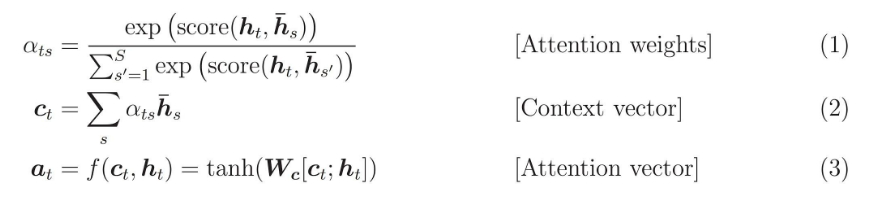

In [10]:
display.Image(os.path.join(os.getcwd(), 'pic/attn_expression.PNG'), height = 200)

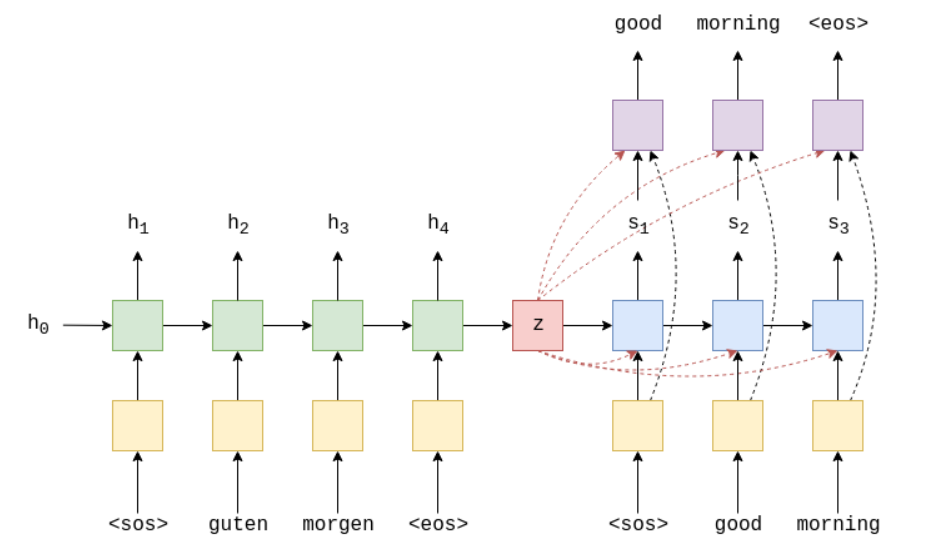

In [9]:
display.Image(os.path.join(os.getcwd(), 'pic/attn_seq2seq.PNG'), height = 400)

## Attention Seq2Seq process
$Output = DecoderRNN(hidden\ state,\ concat(embedded,\ context\ vector))$ <br>
$logits = Linear(concat(Embedded,\ Output,\ Context\ Vector))$ <br>

cf) 논문(Bahdanau)의 구현을 따라서 Encoder의 경우 BiRNN(Bidirectional RNN)을 사용했습니다.

## BiRNN Encoder
기존의 RNN은 한방향으로 정보가 흐르기 때문에 다음과 같은 문제가 발생합니다. <br>
<br>
I want _ <br>

여러분도 아시듯 빈칸에 들어갈 수 있는 말은 굉장히 많습니다. <br>
왜냐하면 문장의 전체 맥락이 주어지지 않아 단어를 한정할 수 없기 때문입니다. <br>
하지만 뒤의 단어에 대한 정보가 다음과 같이 추가로 주어질 경우 빈칸에 들어갈 단어를 한정할 수 있습니다. <br>
I want _ go home. &nbsp; (answer: to)<br>

BiRNN은 양방향으로 정보를 받아들이기 때문에 위의 예시와 같이 모델링 됩니다.

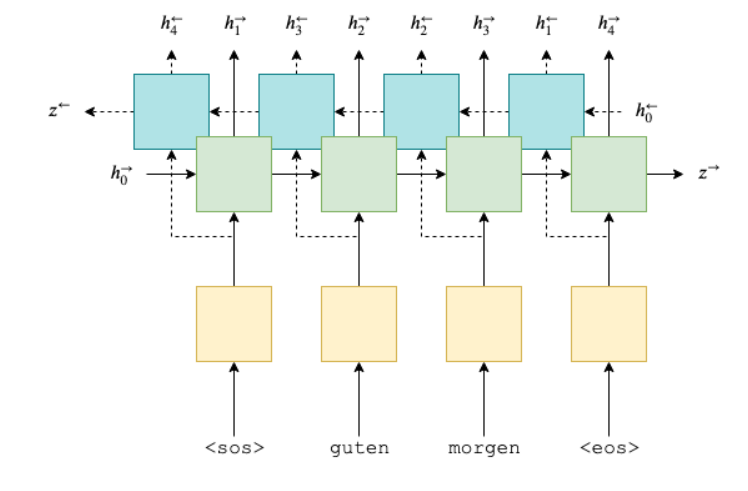

In [13]:
display.Image(os.path.join(os.getcwd(), 'pic/BiRNN.PNG'), height = 350)

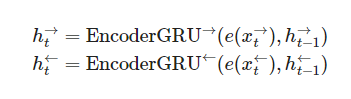

In [3]:
display.Image(os.path.join(os.getcwd(), 'pic/BiRNN_expression.PNG'))
# ->: 정방향, <-: 역방향, e: embedding, h: hidden_state

$encoder\ outs,\ h_n =\ BiRNN\ GRU(input)$<br>
<br>
* size <br>
$input(seq\ length,\ batch\ size,\ hidden\ dim)$ <br>
<br>
$encoder\ outs(seq\ length,\ batch\ size,\ 2*hidden\ dim)$ <br>
$h_n(2*num\ layers,\ batch\ size,\ hidden\ dim)$ <br>

Decoder의 경우 Encoder와 달리 기본적인 RNN(GRU)이기 때문에 size를 다음과 같이 맞춰줘야 합니다. <br>
1) input(batch size, hidden_dim) <br>
2) hidden(batch_size, hidden_dim) <br>
3) encoder outs(seq_length, batch_size, 2 x hidden_dim) <br>

size가 다른 경우는 hidden state만 있으므로 h_n을 concatenation한 후 마지막 차원(2 x hidden_dim)을 바꾸기 위해 linear layer를 사용합니다.<br>
```python
fc = nn.Linear(2*hidden_dim, hidden_dim)

out = fc(concatenation((h_n[0], h_n[1]), dim = -1))
# 학습의 용이성을 위해 activation function 삽입
hidden = activation(out)
```

In [4]:
class BiRNNEncoder(nn.Module):
  def __init__(self, 
               n_tokens,
               emb_dim, 
               hid_dim,
               n_layers = 1,
               drop_p = 0.3):
    super(BiRNNEncoder, self).__init__()
    self.embedding = nn.Embedding(n_tokens, emb_dim)
    self.dropout = nn.Dropout(drop_p)
    self.rnn = nn.GRU(emb_dim, 
                      hid_dim, 
                      n_layers,
                      bidirectional = True)

    self.decoder_fc = nn.Linear(2 * hid_dim, hid_dim)
    
  def forward(self, x):
    embedded = self.dropout(self.embedding(x))
    out, hidden = self.rnn(embedded)
    hidden = torch.cat((hidden[0], hidden[1]), dim = -1) # (batch_size, hid_dim * 2)
    hidden = torch.tanh(self.decoder_fc(hidden))

    return out, hidden

## Attention mechanism
Encoder의 경우 맨 마지막 hidden state(정방향, 역방향)만 반환하므로 각 time step에 대한 정보는 encoder의 output을 통해서 구할 수 있습니다. <br>
즉 $h_{s}$는 encoder outputs, $h_{t}$는 decoder의 이전 hidden state를 통해 attention score를 구할 수 있습니다.<br>

cf) Bahdanau의 Attention mechanism 사용 <br>


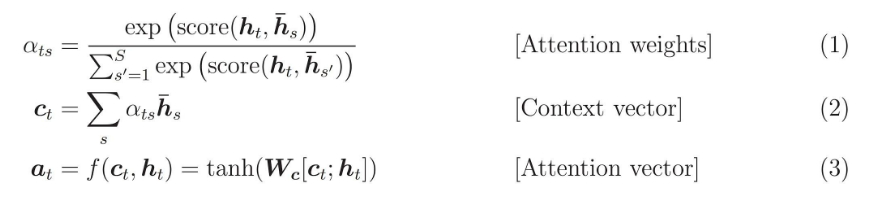

In [2]:
display.Image(os.path.join(os.getcwd(), 'pic/attn_expression.PNG'), height = 200)

```python
#psudo code
def attention_score(encoder outs, decoder prev hidden):
  '''
    decoder prev hidden(batch_size, hidden_dim)
    encoder outs(seq_length, batch_size, 2*hidden_dim)
  '''
  
  return v(tanh(w1(decoder prev hidden) + w2(encoder outs))) 

  # encoder outs과 decoder prev hidden의 size를 맞춰줘야 하므로 w1, w2의 out features를 동일하게 설정 
  # v.out_features = 1

def attention weight(attention_score):
  '''
    attention_score(seq_length, batch_size, 1)
  '''

  return F.softmax(attention_score, dim = 0) # (각 sequence data에 대한 확률을 구해야 하므로 dim = 0)

def context_vector(attention_weight, encoder_outs):
  '''
    attention_weight(seq_length, batch_size, 1)
    encoder_outs(seq_length, batch_size, 2 * hidden_dim)
  '''

  return sum(attention_weight * encoder_outs, dim = 0) # attention_weight(..., 1) -> (..., 2 * hidden_dim) (by broadcasting semantics)
  # weighted sum(가중합)을 sequential data에 따라 연산하므로 dim = 0


```


Attention mechanism을 통해 구한 context vector는 <br>
1) Decoder RNN의 embedded와 함께 input으로 <br>
2) Decoder RNN결과로 산출된 output vector와 embedded와 통합되어 linear layer를 거친 후 logits을 산출하게 됩니다. <br>

```python
# psudo code
Encoder_input = concatenation(embedded, context vector)
out, hidden = EncoderRNN(Encoder_input, hidden)
out = concatenation(out, embedded, context vector)
logits = Linear(out)

```

<br>

In [5]:
class Attention(nn.Module):
  def __init__(self, 
               hid_dim):
    super(Attention, self).__init__()
    self.W1 = nn.Linear(hid_dim, hid_dim)
    self.W2 = nn.Linear(2 * hid_dim, hid_dim)
    self.v = nn.Linear(hid_dim, 1)

  def forward(self, dec_hidden, enc_outs):
    '''
    inputs:
      - dec_hidden(Tensor[batch_size, hid_dim]) 
      - enc_outs(Tensor[seq_length, batch_size, 2 * hid_dim])
    outputs:
      - attn_weight(Tensor[seq_length, batch_size, 1])
      - context_vector(Tensor[batch_size, 2 * hid_dim])
    '''
    score = self.v(torch.tanh(self.W1(dec_hidden) + self.W2(enc_outs))) # (seq_length, bath_size, 1)
    attn_weight = F.softmax(score, dim = 0) # (seq_length, batch_size, 1)
    context_vector = torch.sum((attn_weight * enc_outs), dim = 0) # (batch_size, 2 * hid_dim)
    return attn_weight, context_vector

In [21]:
class AttnDecoder(nn.Module):
  def __init__(self,
               emb_dim,
               hid_dim,
               n_tokens,
               n_layers = 1,
               drop_p = 0):
    super(AttnDecoder, self).__init__()

    self.rnn = nn.GRU(emb_dim + 2*hid_dim, hid_dim)
    self.embedding = nn.Embedding(n_tokens, emb_dim)
    self.dropout = nn.Dropout(drop_p)
    self.attn = Attention(hid_dim)
    self.fc = nn.Linear(3*hid_dim + emb_dim, n_tokens)
    self.trg_n_tokens = n_tokens

  def forward(self, input, hidden, enc_outs):
    '''
    inputs:
      - input(Tensor[batch_size]):
      - hidden(Tensor[batch_size, hid_dim])
      - enc_outs(Tensor[seq_length, batch_size, hid_dim * 2])
    outputs:
      - logits(Tensor[batch_size, trg_n_tokens])
      - hidden(Tensor[batch_size, hid_dim])
    '''
    
    input = input.unsqueeze(0)
    embedded = self.dropout(self.embedding(input)) # (1, batch_size, emb_dim)
    attn_weight, context_vector = self.attn(hidden, enc_outs)
    x = torch.cat((context_vector.unsqueeze(0), embedded), dim = 2) # (1, batch_size, emb_dim + 2 * hid_dim)
    out, hidden = self.rnn(x, hidden.unsqueeze(0)) # out, hidden: (1, batch_size, hid_dim)  
    
    # out: (1, bs, hid_dim), context: (bs, 2*hid_dim), embedded: (1, bs, emb_dim)
    out = torch.cat((out.squeeze(0), context_vector, embedded.squeeze(0)), dim = -1)
    logits = self.fc(out)
    return logits.squeeze(0), hidden.squeeze(0)

In [22]:
encoder = BiRNNEncoder(n_tokens = src_n_tokens,
                  emb_dim = emb_dim,
                  hid_dim = hid_dim,
                  n_layers = 1,
                  drop_p = 0.5)
decoder = AttnDecoder(emb_dim,
                      hid_dim,
                      trg_n_tokens,
                      drop_p = 0)
model = seq2seq.Seq2Seq(encoder, decoder, device)
with torch.no_grad():
  model.eval()
  logits = model(batch[0][0], batch[1][0]) # test

In [23]:
# split data into train, val
train_ratio = 0.8
train_batch = (batch[0][:int(len(batch[0])*train_ratio)], batch[1][:int(len(batch[0])*train_ratio)])
val_batch = (batch[0][int(len(batch[0])*train_ratio):], batch[1][int(len(batch[0])*train_ratio):])

In [26]:
best_model = engine.run(model, 
                 train_batch, 
                 val_batch, 
                 loss_fn = nn.CrossEntropyLoss(), 
                 optimizer = optim.Adam(model.parameters(), lr = learning_rate), 
                 num_epochs = 20,
                 device = device, 
                 print_every = 1)

Epoch| 1/20
train loss: 1.2633036498960695
val loss: 4.335380499561627
Epoch| 2/20
train loss: 0.8984831243753433
val loss: 4.003439361850421
Epoch| 3/20
train loss: 0.8271279609517047
val loss: 3.939225440224012
Epoch| 4/20
train loss: 0.7263752755365873
val loss: 3.906046763062477
Epoch| 5/20
train loss: 0.7293283071957136
val loss: 3.8823514928420386
Epoch| 6/20
train loss: 0.666190715212571
val loss: 3.714456950624784
Epoch| 7/20
train loss: 0.6164490760941255
val loss: 3.7301204750935235
Epoch| 8/20
train loss: 0.5985076035323896
val loss: 3.6563456505537033
Epoch| 9/20
train loss: 0.572482169145032
val loss: 3.6340570598840714
Epoch| 10/20
train loss: 0.5806366271094272
val loss: 3.6957877377669015
Epoch| 11/20
train loss: 0.5597309899173285
val loss: 3.5582362562417984
Epoch| 12/20
train loss: 0.5800884277412766
val loss: 3.5537956009308496
Epoch| 13/20
train loss: 0.5491896463852179
val loss: 3.4604779109358788
Epoch| 14/20
train loss: 0.5052413984348899
val loss: 3.55977401137

## 모델 결과값(validation dataset) 확인

In [27]:
visualize_result.print_val(best_model,
                           input_lang,
                           output_lang,
                           val_batch,
                           device)

source sentence:  j ai des prejuges . <EOS> <PAD> <PAD> <PAD>
answer translation:  i m prejudiced . <EOS> <PAD> <PAD> <PAD> <PAD>
pred translation :  i m very shy . <EOS> <PAD> <PAD> <PAD>
 
source sentence:  c est un bon nageur . <EOS> <PAD> <PAD>
answer translation:  he is a good swimmer . <EOS> <PAD> <PAD>
pred translation :  he is a good good . <EOS> <PAD> <PAD>
 
source sentence:  il est mon ami . <EOS> <PAD> <PAD> <PAD>
answer translation:  he is my friend . <EOS> <PAD> <PAD> <PAD>
pred translation :  he s my friend . <EOS> <PAD> <PAD> <PAD>
 
source sentence:  vous etes une opportuniste . <EOS> <PAD> <PAD> <PAD>
answer translation:  you re opportunistic . <EOS> <PAD> <PAD> <PAD> <PAD>
pred translation :  you re opportunistic . <EOS> <PAD> <PAD> <PAD> <PAD>
 
source sentence:  je suis completement epuise . <EOS> <PAD> <PAD> <PAD>
answer translation:  i m completely exhausted . <EOS> <PAD> <PAD> <PAD>
pred translation :  i m completely exhausted . <EOS> <PAD> <PAD> <PAD>
 
source 